# Predicting Customer Expenditure on Detergents & Paper Products

The dataset is take from UCI Machine Learning repository

In [1]:
#Importing standard libraries and exploring the data
import numpy as np
import pandas as pd
df = pd.read_csv('Wholesale customers data.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [2]:
#to be used later
df1 = df.copy()
df2 = df.copy()

In [3]:
df.drop(['Channel', 'Region'], axis=1, inplace=True)

This cell shows the statistics about annual spending on fresh products, milk products, grocery, frozen products, detergent & paper products and delicatessen products, all of which are continuous variables.

In [4]:
df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Here we explore the Quartiles of Fresh Products' and Frozen products' prices and will later use for visualizing general trend as well as finding outliers

In [5]:
from IPython.display import display
q1_fresh = 3127.75
display(df.loc[df['Fresh']<3127.75, :].head())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
16,1020,8816,12121,134,4508,1080
31,2612,4339,3133,2088,820,985
34,1502,1979,2262,425,483,395
35,688,5491,11091,833,4239,436
43,630,11095,23998,787,9529,72


In [6]:
q1_frozen = 742.25
df.loc[df['Frozen']<q1_frozen, :].head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
5,9413,8259,5126,666,1795,1451
6,12126,3199,6975,480,3140,545
8,5963,3648,6192,425,1716,750
12,31714,12319,11757,287,3881,2931


In [7]:
q3_frozen = 3554.25
df.loc[df['Frozen'] > q3_frozen, :].head(8)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
10,3366,5403,12974,4400,5977,1744
22,31276,1917,4469,9408,2381,4334
23,26373,36423,22019,5154,4337,16523
33,29729,4786,7326,6130,361,1083
39,56159,555,902,10002,212,2916
40,24025,4332,4757,9510,1145,5864


Let us extract the rows with values for Fresh and Frozen products at the lower and upper extremes at the same time

In [8]:
indices = [43, 12, 39]
df2 = pd.DataFrame(df.loc[indices], columns = df.columns).reset_index(drop = True)
df2

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,630,11095,23998,787,9529,72
1,31714,12319,11757,287,3881,2931
2,56159,555,902,10002,212,2916


Plotting the above values, which also shows those rows with some of the maximum difference between the prices for fresh and frozen products

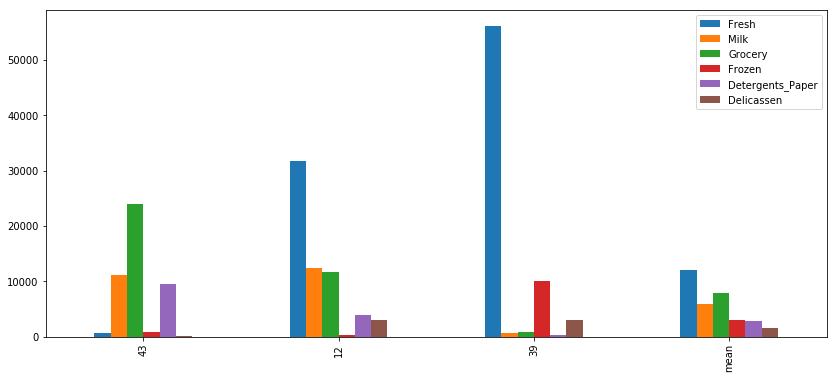

In [10]:
import seaborn as sns
mean_df = df.describe().loc['mean', :]
df2_ext = df2.append(mean_df)
df2_ext.index = indices+['mean']
df2_ext.plot(kind='bar', figsize=(14,6))

The prices for Detergent & paper products and grocery products are highly correlated; while those of fresh products & grocery products are the least correlated

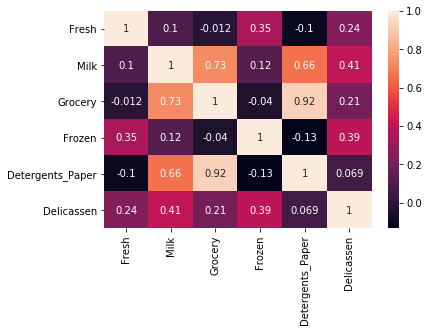

In [11]:
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, annot=True)

Andrews curves, to visualize high dimensional data (Although in our case the data does not have very high dimension). We can see the range of values and their density for the 3 regions. Region 3 has considerable number of very high values for the products' price

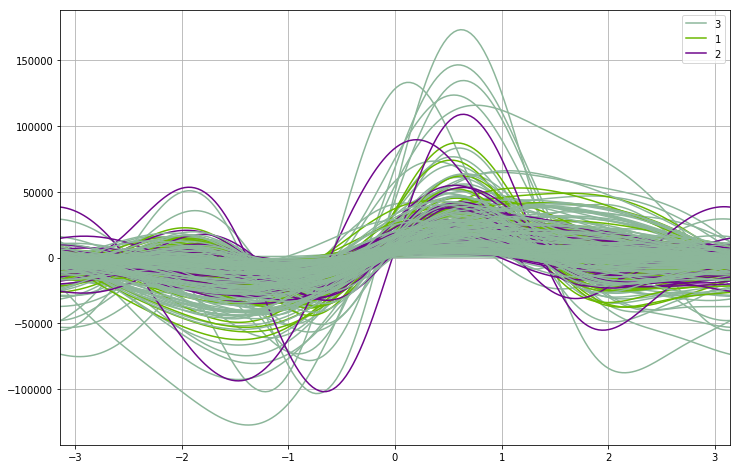

In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm
from pandas.plotting import andrews_curves
from pylab import rcParams
rcParams['figure.figsize'] = 12,8
andrews_curves(df1, 'Region')

Text(0.5, 1.0, "Detergents_Paper products' price v/s Region")

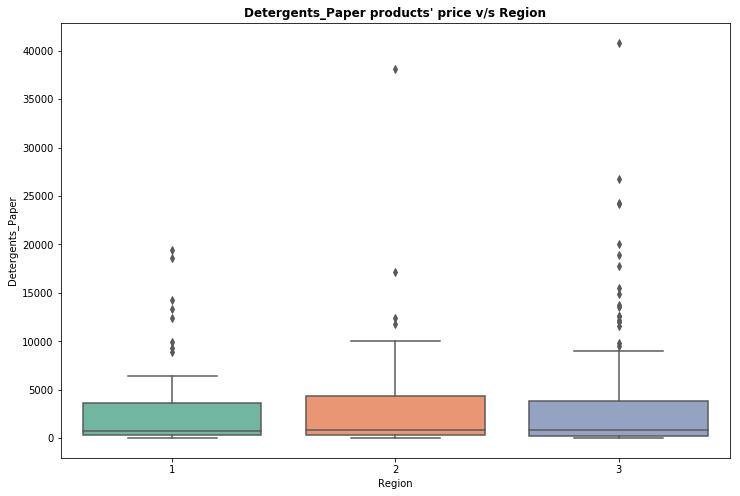

In [19]:
sns.boxplot(x="Region", y="Detergents_Paper",data=df1, palette="Set2")
plt.title("Detergents_Paper products' price v/s Region", fontweight='bold')

## Outlier Detection

There are many methods for detecting outliers, some of them being using visualization techniques like KMeans, DBSCAN, Z-Score, Isolation Forests. A centroid in KMeans and a point very distant from it can be thought of being analogous to lying in low bandwidth area (extreme) when we plot a Gaussian distribution with origin as the centroid.

In this analysis, we use Tukey's method, according to which points more than 3rd Quartile by 1.5 times interquartile range or more, or which are less than 1st Quartile by 1.5 times interquartile range or more can be considered as outliers. 

In [20]:
log_df = np.log(df)
import itertools
outliers_list = []
all_outlier_rows = []
duplicate_outliers = []
for feature in log_df.columns:
    Q1 = np.percentile(log_df.loc[:, feature], 25)
    Q3 = np.percentile(log_df.loc[:, feature], 75)
    step_size = 1.5*(Q3-Q1)
    outlier_rows = log_df.loc[~((log_df[feature] >=Q1-step_size) & (log_df[feature] <=Q3+step_size)), :]
    outliers_list.append('Outliers w.r.t. {} are rows with indices: {}'.format(feature, list(outlier_rows.index)))
    all_outlier_rows.append(list(outlier_rows.index))
    
outliers = list(itertools.chain.from_iterable(all_outlier_rows))
uniq_outliers = list(set(list(itertools.chain.from_iterable(all_outlier_rows))))

for i in outliers:
    if outliers.count(i)>1:
        duplicate_outliers.append(i)
        
print(outliers_list)
print('\nAll Outlier Rows', outliers)
print('\nAll Unique Outlier Rows:', uniq_outliers)
print('\nOutlier Rows w.r.t. More than 1 Feature:', list(set(duplicate_outliers)))

['Outliers w.r.t. Fresh are rows with indices: [65, 66, 81, 95, 96, 128, 171, 193, 218, 304, 305, 338, 353, 355, 357, 412]', 'Outliers w.r.t. Milk are rows with indices: [86, 98, 154, 356]', 'Outliers w.r.t. Grocery are rows with indices: [75, 154]', 'Outliers w.r.t. Frozen are rows with indices: [38, 57, 65, 145, 175, 264, 325, 420, 429, 439]', 'Outliers w.r.t. Detergents_Paper are rows with indices: [75, 161]', 'Outliers w.r.t. Delicassen are rows with indices: [66, 109, 128, 137, 142, 154, 183, 184, 187, 203, 233, 285, 289, 343]']

All Outlier Rows [65, 66, 81, 95, 96, 128, 171, 193, 218, 304, 305, 338, 353, 355, 357, 412, 86, 98, 154, 356, 75, 154, 38, 57, 65, 145, 175, 264, 325, 420, 429, 439, 75, 161, 66, 109, 128, 137, 142, 154, 183, 184, 187, 203, 233, 285, 289, 343]

All Unique Outlier Rows: [128, 264, 137, 142, 145, 154, 412, 285, 161, 289, 420, 38, 171, 429, 175, 304, 305, 439, 183, 57, 184, 187, 65, 66, 193, 325, 75, 203, 81, 338, 86, 343, 218, 95, 96, 353, 98, 355, 356, 35

In [21]:
clean_df = log_df.drop(log_df.index[list(set(duplicate_outliers))]).reset_index(drop=True)

As we can see, we detected the rows which are outliers for more than 1 feature (called duplicate_outliers) should be removed, and these are 5 in number. Hence the new shape is reduced by 5 as seen below..

In [22]:
log_df.shape, clean_df.shape

((440, 6), (435, 6))

In [23]:
log_df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


## DBSCAN
DBSCAN stands for Density Based Spatial Clustering of applications with noise, and is an unsupervised learning algorithm which usually performs better in clustering data points than its other clustering counterparts like KMeans & FuzzyKMeans. It does not require to explicitly specify number of clusters, unlike KMeans, and uses a distance measurement and minimum number of points for clustering. It can form clusters of any arbitrary shape (which is usually the case in real life), is robust to noisy data, and performs well in detecting outliers in low density regions.

Text(0.5, 1.0, 'Milk & Fresh')

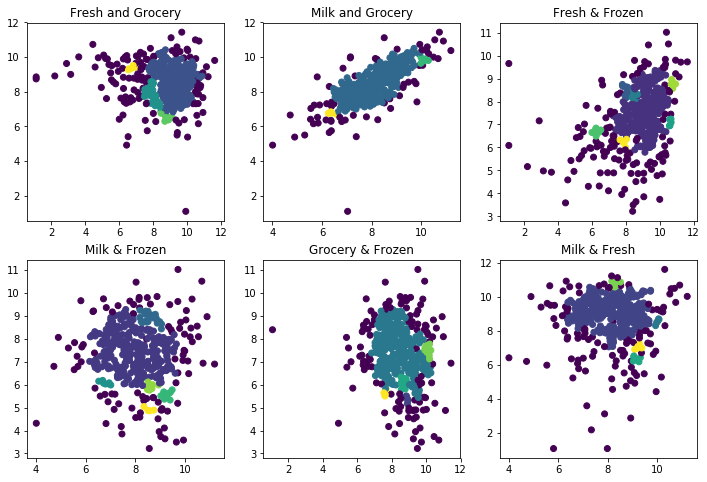

In [24]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
outlier_detection = DBSCAN(eps =.25, metric='euclidean')

plt.subplot(2,3,1)
clusters_F_G = outlier_detection.fit_predict(log_df[['Fresh', 'Grocery']])
plt.scatter(x=log_df['Fresh'],y=log_df['Grocery'], c=clusters_F_G)
plt.title("Fresh and Grocery")

plt.subplot(2,3,2)
clusters_M_G = outlier_detection.fit_predict(log_df[['Milk', 'Grocery']])
plt.scatter(x=log_df['Milk'],y=log_df['Grocery'], c=clusters_M_G)
plt.title("Milk and Grocery")

plt.subplot(2,3,3)
clusters_F_Fo = outlier_detection.fit_predict(log_df[['Fresh', 'Frozen']])
plt.scatter(x=log_df['Fresh'],y=log_df['Frozen'], c=clusters_F_Fo)
plt.title("Fresh & Frozen")

plt.subplot(2,3,4)
clusters_M_Fo = outlier_detection.fit_predict(log_df[['Milk', 'Frozen']])
plt.scatter(x=log_df['Milk'],y=log_df['Frozen'], c=clusters_M_Fo)
plt.title("Milk & Frozen")

plt.subplot(2,3,5)
clusters_G_Fo = outlier_detection.fit_predict(log_df[['Grocery', 'Frozen']])
plt.scatter(x=log_df['Grocery'],y=log_df['Frozen'], c=clusters_G_Fo)
plt.title("Grocery & Frozen")

plt.subplot(2,3,6)
clusters_M_F = outlier_detection.fit_predict(log_df[['Milk', 'Fresh']])
plt.scatter(x=log_df['Milk'],y=log_df['Fresh'], c=clusters_M_F)
plt.title("Milk & Fresh")



Now let us check the change in performance/clusters (if any) on the data prepared after removing duplicate outliers

Text(0.5, 1.0, 'Milk & Fresh')

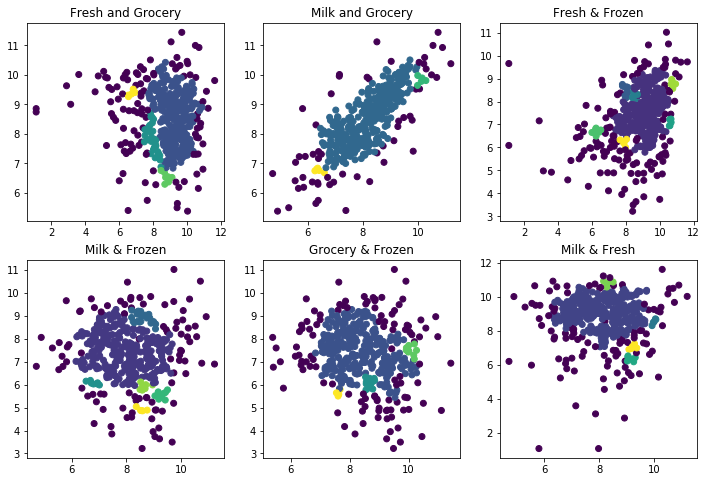

In [25]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
outlier_detection = DBSCAN(eps =.25, metric='euclidean')

plt.subplot(2,3,1)
clusters_F_G = outlier_detection.fit_predict(clean_df[['Fresh', 'Grocery']])
plt.scatter(x=clean_df['Fresh'],y=clean_df['Grocery'], c=clusters_F_G)
plt.title("Fresh and Grocery")

plt.subplot(2,3,2)
clusters_M_G = outlier_detection.fit_predict(clean_df[['Milk', 'Grocery']])
plt.scatter(x=clean_df['Milk'],y=clean_df['Grocery'], c=clusters_M_G)
plt.title("Milk and Grocery")

plt.subplot(2,3,3)
clusters_F_Fo = outlier_detection.fit_predict(clean_df[['Fresh', 'Frozen']])
plt.scatter(x=clean_df['Fresh'],y=clean_df['Frozen'], c=clusters_F_Fo)
plt.title("Fresh & Frozen")

plt.subplot(2,3,4)
clusters_M_Fo = outlier_detection.fit_predict(clean_df[['Milk', 'Frozen']])
plt.scatter(x=clean_df['Milk'],y=clean_df['Frozen'], c=clusters_M_Fo)
plt.title("Milk & Frozen")

plt.subplot(2,3,5)
clusters_G_Fo = outlier_detection.fit_predict(clean_df[['Grocery', 'Frozen']])
plt.scatter(x=clean_df['Grocery'],y=clean_df['Frozen'], c=clusters_G_Fo)
plt.title("Grocery & Frozen")

plt.subplot(2,3,6)
clusters_M_F = outlier_detection.fit_predict(clean_df[['Milk', 'Fresh']])
plt.scatter(x=clean_df['Milk'],y=clean_df['Fresh'], c=clusters_M_F)
plt.title("Milk & Fresh")

In [26]:
df1.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Applying simple log based scaling for PCA

In [27]:
y = df1['Region']
df1.drop(['Channel', 'Region'], axis=1, inplace=True)
df1_log = np.log(df1)

In [28]:
df1_log.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


## Principal Component Analysis (PCA)

Principal Component Analysis is a method to reduce the dimensionality of data and at the same time retain most of the information contained in original variables. Principal Components are mutually uncorrelated linear combinations of two or more variables (ideally highly uncorrelated), which point in the direction of eigen vector of the feature covariance matrix, and with length equal to eigen value (which also is equal to the magnitude of variance explained by that principal component), and may not make physical sense, as they, by themselves are not real-world variables. These carry more information than their counterpart variables and may span many dimensions depending upon the number of principal components we use, and they are mutually perpendicular (always). Mathematically, one of its variant, kernel PCA uses the kernel trick which involves dot product of the orthogonal components and eventually finds a low dimensional *non-linear* subspace of a higher dimensional space to map the data. It thus projects the data onto a higher dimension included by the respective principal components, which eventually finds itself to lie on a low dimesional subspace of that dimension. So, we first increase the dimensionality to be able to decrease it. The two principal components below explain about 72% of variance of the data, the rest of the principal components (not included in this notebook) explain the remaining 28% variance. However, the 3 classes in this case do not appear to be well separated. This separation can be made more robust and accurate by introducing more principal components and plotting them on higher dimension.

Text(0.5, 1.0, 'PCA Visualization for 3 Classes (Regions)')

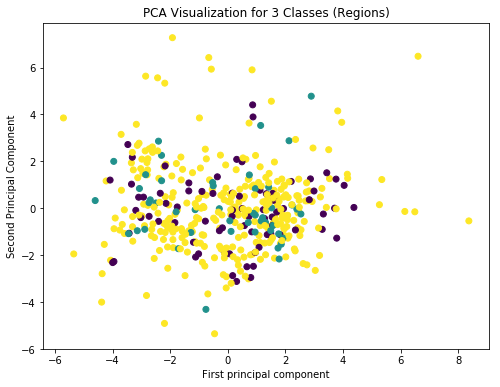

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df1_log)
X = pca.transform(df1_log)
plt.figure(figsize=(8,6), facecolor=(1, 1, 1))
plt.scatter(X[:,0],X[:,1],c=y)
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title('PCA Visualization for 3 Classes (Regions)')


Variance Explained by Component 1 = 0.44237416641831734
Variance Explained by Component 2 = 0.2765710653187554


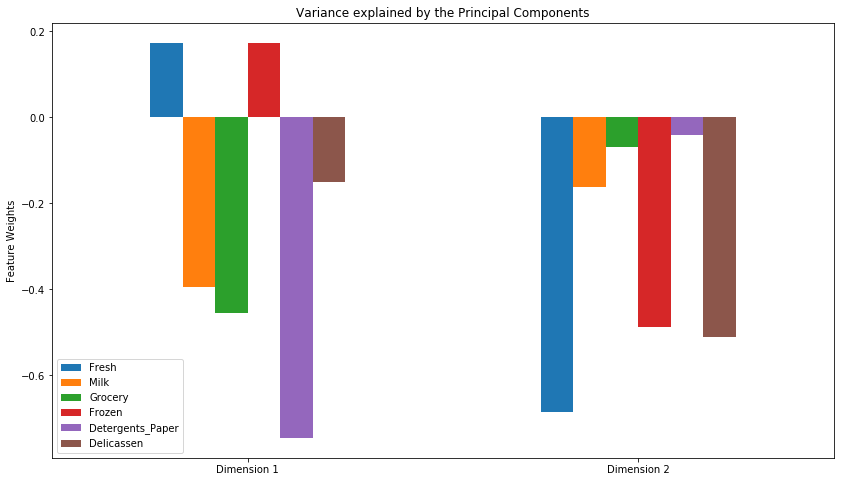

In [30]:
def pca_results(good_data, pca):
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    fig, ax = plt.subplots(figsize = (14,8), facecolor=(1, 1, 1))
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    plt.title('Variance explained by the Principal Components')
    for i, ev in enumerate(pca.explained_variance_ratio_):
        print('Variance Explained by Component {} = {}'.format(i+1, ev))


pca_results = pca_results(df1_log, pca)

In [31]:
pca_df = pd.DataFrame(X, columns=['Dimension 1', 'Dimension 2'])

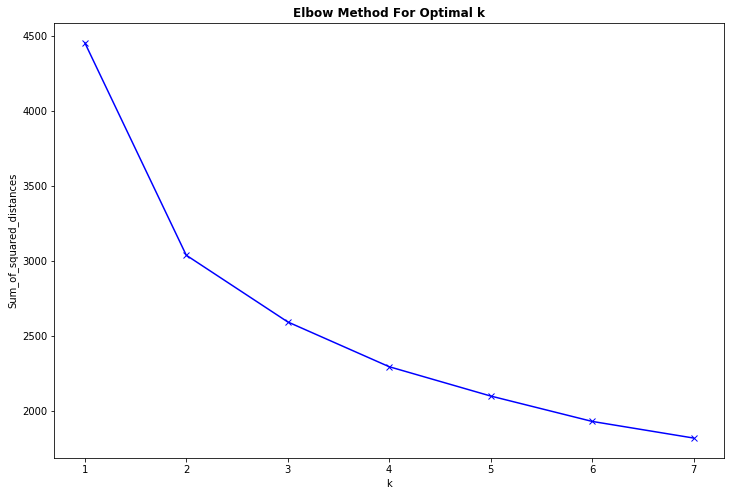

In [32]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(clean_df)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.rcParams['figure.facecolor'] = '1'
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k', fontweight='bold')
plt.show()

In [33]:
from sklearn.metrics import silhouette_score
K = range(2,9)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pca_df)
    preds = km.predict(X)
    score = silhouette_score(pca_df, preds, metric='mahalanobis')
    print("Average silhoutte score for {} clusters = {}".format(k, score))

Average silhoutte score for 2 clusters = 0.37418369743048163
Average silhoutte score for 3 clusters = 0.3832756386764307
Average silhoutte score for 4 clusters = 0.3299731022819437
Average silhoutte score for 5 clusters = 0.3441577969102045
Average silhoutte score for 6 clusters = 0.34468648011266834
Average silhoutte score for 7 clusters = 0.35107458092938937
Average silhoutte score for 8 clusters = 0.3543375904879296


## KMeans Clusters

The elbow method helps to identify the optimum number of clusters. We select that cluster for which the marginal decrease in loss is more than the loss obtained by previous clusters. One can also make use of the silhoutte score for such analysis, which basically shows how cohesive the data points within a cluster are to that spcific cluster as opposed to nearby clusters on an average, using distance based metrics. From the above analysis, the silhoutte score for cluster 3 is the highest and so we select 3 K-clusters for our analysis.

In the below graph, we can see the clusters as predicted by KMeans along with respective centroids. One key difference which can be observed is the difference in the shape of the clusters below and that predicted by DBSCAN above. 

Text(0.5, 1.0, 'Kmeans clustering on PCA reduced data')

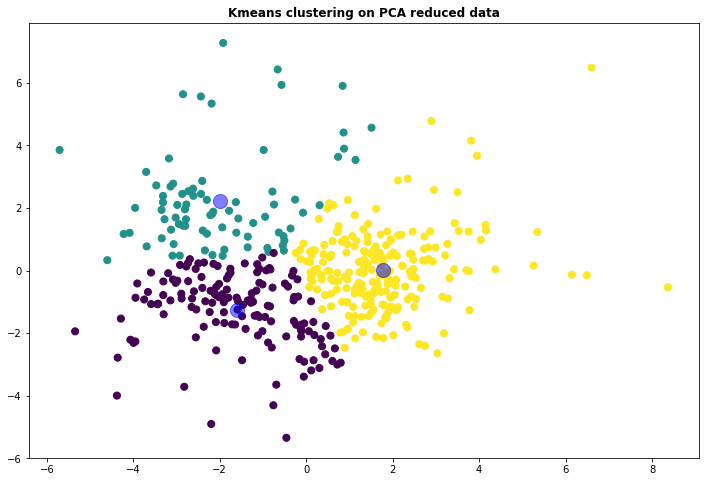

In [34]:
kmeans_fit = KMeans(n_clusters=3).fit(X)
y = kmeans_fit.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
centers = kmeans_fit.cluster_centers_
plt.scatter(centers[:,0], centers[:, 1], c='blue', s=200, alpha=0.5)
plt.title('Kmeans clustering on PCA reduced data', fontweight='bold')

In [35]:
df2 = pd.read_csv('Wholesale customers data.csv')
df2.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [36]:
centers.shape, centers[:, 1].shape

((3, 2), (3,))

In [37]:
clean_df = df2.drop(df2.index[list(set(duplicate_outliers))]).reset_index(drop=True)

In [38]:
clean_df.head(), clean_df.shape

(   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
 0        2       3  12669  9656     7561     214              2674        1338
 1        2       3   7057  9810     9568    1762              3293        1776
 2        2       3   6353  8808     7684    2405              3516        7844
 3        1       3  13265  1196     4221    6404               507        1788
 4        2       3  22615  5410     7198    3915              1777        5185,
 (435, 8))

## Linear Regression

#### If we look at the correlation heatmap generated earlier again, we can see that the most correlated variables are Grocery products' prices and Detergent papers' prices (both continuous variables). Hence, if our task is, say, to predict detergents papers' prices using other variables, it is intiuitive that using Grocery prices as a feature for linear regression will likely give better results than using any other variable as a feature. Below we construct the line of best fit and calculate the performance metrics for the same.

In [39]:
X.shape, y.shape

((440, 2), (440,))

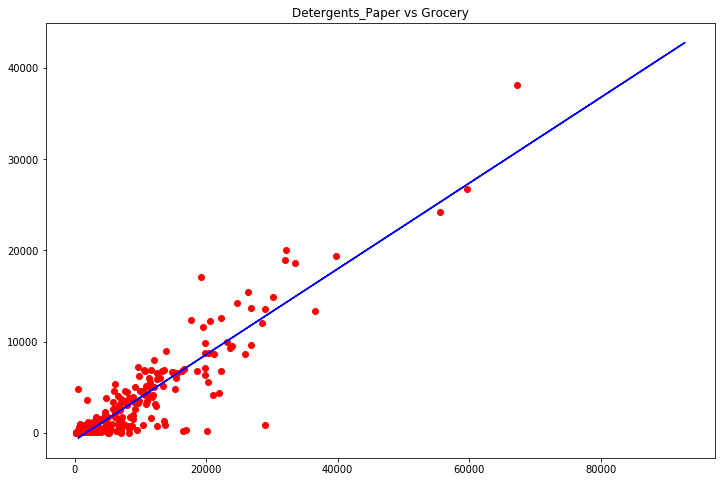

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
X1 = clean_df[['Grocery']]
y1 = clean_df[['Detergents_Paper']]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1,test_size=0.33, random_state=42)
X_train1 = np.array(X_train1).reshape(-1,1)
y_train1 = np.array(y_train1).reshape(-1,1)
model = LinearRegression()
model.fit(X_train1,y_train1)
y_pred1 = model.predict(X_test1)
plt.title('Detergents_Paper vs Grocery')
plt.scatter(X_train1,y_train1, color = 'red')
plt.plot(X_test1, y_pred1, color='b')


Text(0.5, 1.0, 'Residuals of Regression')

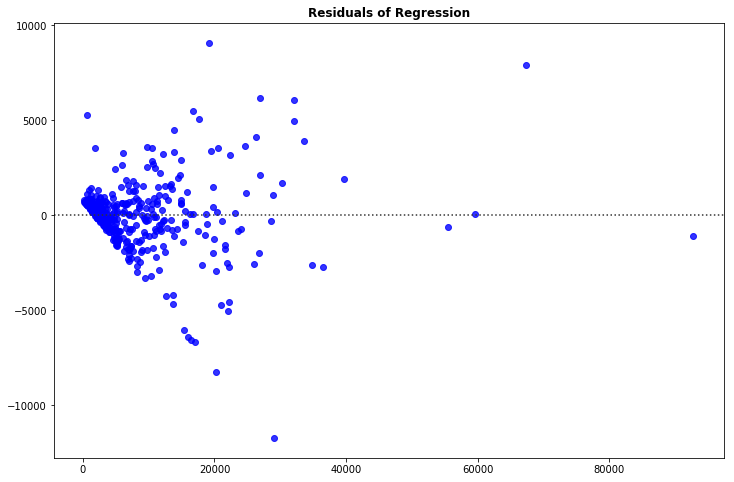

In [41]:
X1 = np.array(X1).reshape(-1,1)
y1 = np.array(y1).reshape(-1,1)
model.fit(X1,y1)
sns.residplot(X1, y1, color='b')
plt.title('Residuals of Regression', fontweight='bold')

In [42]:
import math
from sklearn.metrics import mean_squared_error
print('RMSE :', np.sqrt(mean_squared_error(y_pred1, y_test1)))

RMSE : 1536.1323320776569


#### Using Tree Based Regressors and all variables as features for the regression problem, the linear regressor still outperforms other tree based regressors

In [44]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

regressors = [xgb.XGBRegressor(), GradientBoostingRegressor(), RandomForestRegressor()]
 
for reg in regressors:
    X1 = clean_df[['Channel','Region','Fresh', 'Milk', 'Grocery', 'Frozen', 'Delicassen']]
    y1 = clean_df[['Detergents_Paper']]
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1,test_size=0.33, random_state=42)
    X_train1 = np.array(X_train1)
    y_train1 = np.array(y_train1)
    reg.fit(X_train1, y_train1)
    y_pred = reg.predict(np.array(X_test1))
    print('RMSE of {}={}'.format(reg, np.sqrt(mean_squared_error(y_pred, y_test1))))

RMSE of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)=1928.651973666044
RMSE of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)=1672.4980875988574
RMSE o

C:\Users\user\Downloads\anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Downloads\anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Downloads\anaconda\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
